In [1]:
import json
import numpy as np
import pandas as pd
import concurrent.futures
import matplotlib.pyplot as plt

from math import sqrt
from scipy.special import softmax
from scipy.optimize import minimize
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

In [2]:
network_analytics = pd.read_csv('./data/Network_Analytics.csv')
series = pd.Series(network_analytics['OutboundUtilzation (%)'])

In [3]:
statistics, pval, usedlag, nobs, _, _ = adfuller(network_analytics['OutboundUtilzation (%)'], autolag='AIC')
if pval < 0.05:
    print(f"Data is stationary {statistics} {pval} {usedlag} {nobs}.")
else:
    print(f"Data is not stationary {statistics} {pval} {usedlag} {nobs}")

Data is stationary -12.704162687630873 1.0639878489319919e-23 49 25581.


In [4]:
X = series.values
size = int(len(X) * 0.80)
train, test = X[0:size], X[size:len(X)]

In [5]:
MA_model = ARIMA(endog=train, order=(0, 0, usedlag))
results = MA_model.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                20504
Model:                ARIMA(0, 0, 49)   Log Likelihood              -73075.412
Date:                Wed, 20 Dec 2023   AIC                         146252.825
Time:                        20:00:50   BIC                         146657.172
Sample:                             0   HQIC                        146384.955
                              - 20504                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         60.4129      0.828     72.966      0.000      58.790      62.036
ma.L1          0.9629      0.006    166.410      0.000       0.952       0.974
ma.L2          0.7664      0.009     85.315      0.0

In [6]:
with open('coefs_ma.json', 'w') as file:
    json.dump(results.params.tolist(), file)

In [7]:
results.save('MA.pkl')

In [16]:
results = ARIMAResults.load('MA.pkl')

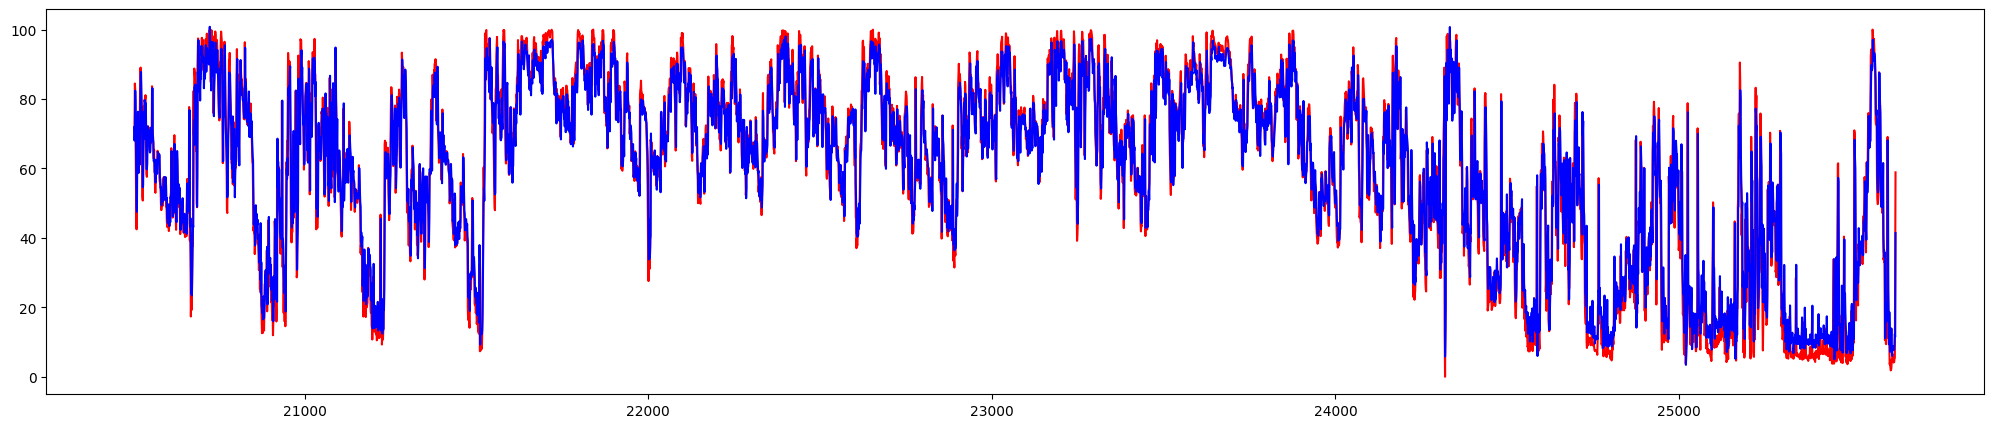

In [8]:
coef = results.params
# Grab last x values of the train dataset
history = train[len(train)-usedlag:]
# Compute their prediction
pred = results.predict(start=len(train) - usedlag + 1, end=len(train))
# Compute error between actual and prediction
errors = np.array(history - pred).tolist()

predictions = list()
for t in range(len(test)):
    yhat = coef[0]
    for d in range(usedlag):
        yhat += coef[d+1] * errors[usedlag-d-1]
        obs = X[t]
    predictions.append(yhat)

    errors.pop(0)
    errors.append(X[len(train) + t] - yhat)

fig, ax = plt.subplots(figsize=(25, 5))
ax.plot(range(size, len(network_analytics)),network_analytics['OutboundUtilzation (%)'][size:len(network_analytics)], color='r')
ax.plot(range(size, len(network_analytics)), predictions, color='b')

In [161]:
def symmetric_mean_absolute_percentage_error(A, F):
    return 100/len(A) * np.sum(np.abs(F - A) / ((np.abs(A) + np.abs(F)) / 2))

In [163]:
rmse = sqrt(mean_squared_error(test, predictions))
print(f"RMSE for {usedlag} lagged values: {rmse}")

mape = mean_absolute_percentage_error(test, predictions)
print(f"MAPE for {usedlag} lagged values: {mape}")

smape = symmetric_mean_absolute_percentage_error(test, predictions)
print(f"SMAPE for {usedlag} lagged values: {smape}")

mae = mean_absolute_error(test, predictions)
print(f"MAE for {usedlag} lagged values: {mae}")

RMSE for 49 lagged values: 7.489079675627363
MAPE for 49 lagged values: 23.85254381125116
SMAPE for 49 lagged values: 13.250629378855722
MAE for 49 lagged values: 5.158979576380235


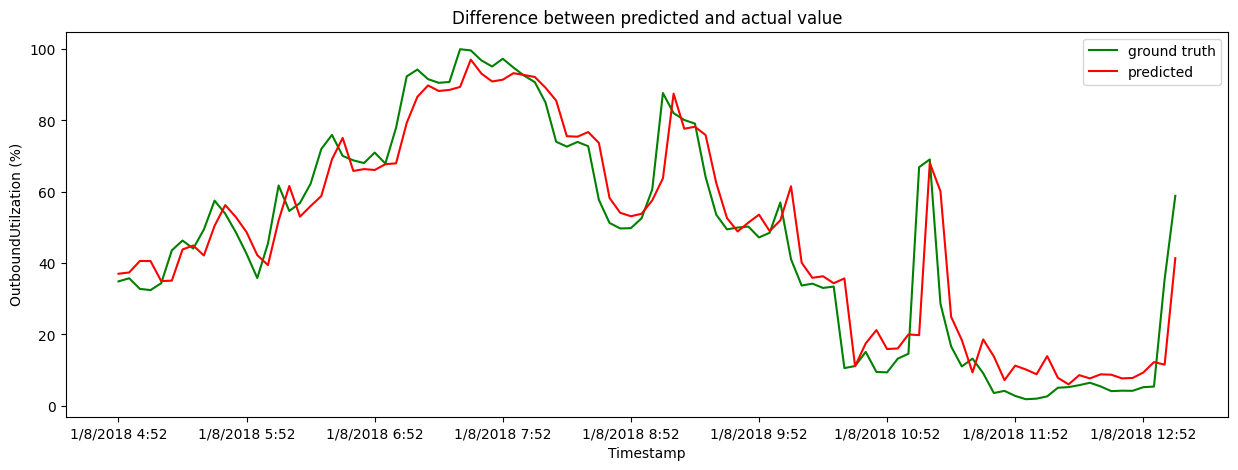

In [157]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(network_analytics['Timestamp'][-100:], test[len(test)- 100:], color='g', label='ground truth')
ax.plot(network_analytics['Timestamp'][-100:], predictions[len(predictions) - 100:], color='r', label='predicted')
plt.title('Difference between predicted and actual value')
plt.xticks(network_analytics['Timestamp'][-100::12])
plt.legend(loc='best')
plt.ylabel('OutboundUtilzation (%)')
plt.xlabel('Timestamp')
plt.show()

## Simple Moving Avarage

Test RMSE: 10.020, Window size: 2
Test RMSE: 10.944, Window size: 3
Test RMSE: 11.719, Window size: 4
Test RMSE: 12.299, Window size: 5
Test RMSE: 12.707, Window size: 6
Test RMSE: 13.027, Window size: 7
Test RMSE: 13.258, Window size: 8
Test RMSE: 13.397, Window size: 9
Test RMSE: 13.489, Window size: 10
Test RMSE: 13.547, Window size: 11
Test RMSE: 13.588, Window size: 12
Test RMSE: 13.681, Window size: 13
Test RMSE: 13.816, Window size: 14
Test RMSE: 13.972, Window size: 15
Test RMSE: 14.139, Window size: 16
Test RMSE: 14.300, Window size: 17
Test RMSE: 14.446, Window size: 18
Test RMSE: 14.582, Window size: 19
Test RMSE: 14.695, Window size: 20
Test RMSE: 14.780, Window size: 21


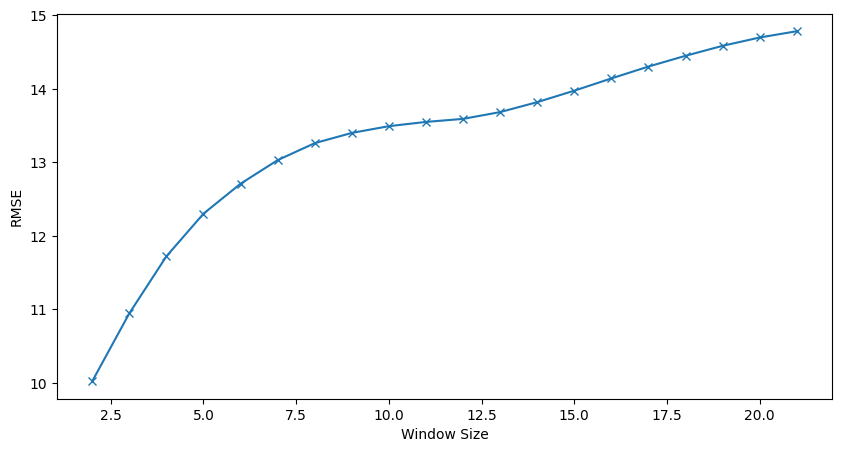

In [62]:
errors = []
range_size = range(2, 22)
for window in range_size:
    X = series.values
    history = [X[i] for i in range(window)]
    test = [X[i] for i in range(window, len(X))]
    predictions = list()
    # walk forward over time steps in test
    for t in range(len(test)):
        length = len(history)
        yhat = np.mean([history[i] for i in range(length-window,length)])
        obs = test[t]
        predictions.append(yhat)
        history.append(obs)
        # if t % 1000 == 0:
        #     print('predicted=%f, expected=%f' % (yhat, obs))
    error = sqrt(mean_squared_error(test, predictions))
    errors.append(error)
    print(f'Test RMSE: {error:.3f}, Window size: {window}')
    # plot
    # plt.figure(figsize=(15,7))
    # plt.plot(test)
    # plt.plot(predictions, color='red')
    # plt.show()

fig, ax = plt.subplots(figsize=(10, 5))
ax.set_ylabel('RMSE')
ax.set_xlabel('Window Size')
ax.plot(range_size, errors, marker='x')


In [29]:
def absolute_error_statistics(original : np.array, predicted : np.array):
    assert len(original) == len(predicted)
    return np.absolute(original - predicted)

In [63]:
desc_sma = {}

range_size = range(2, 22)
for window in range_size:
    X = series.values
    history = [X[i] for i in range(window)]
    predictions = list()
    # walk forward over time steps in test
    for t in range(len(X)):
        length = len(history)
        yhat = np.mean([history[i] for i in range(length-window,length)])
        obs = X[t]
        predictions.append(yhat)
        history.append(obs)
    result = absolute_error_statistics(X, np.array(predictions))
    desc_sma[f'Window size {window}'] = result

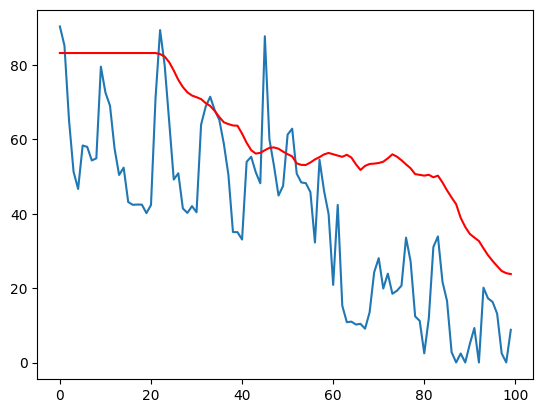

In [31]:
# zoom plot
plt.plot(test[0:100])
plt.plot(predictions[0:100], color='red')
plt.show()

## Weighted Moving Average

In [32]:
def generate_random_weights(size : int) -> np.array :
    random_array = np.random.dirichlet(np.ones(size))
    while (np.sum(random_array) != 1.0):
        random_array = np.random.dirichlet(np.ones(size))
    return random_array

X = series.values

def optim_func(weights, X, window):
    history = [X[i] for i in range(window)]
    test = [X[i] for i in range(window, len(X))]
    predictions = list()
    for t in range(len(test)):
        length = len(history)
        yhat = np.average([history[i] for i in range(length-window,length)], weights=weights)
        obs = test[t]
        predictions.append(yhat)
        history.append(obs)
    error = sqrt(mean_squared_error(test, predictions))
    return error


def run_wma(window : int):
    res = minimize(optim_func, generate_random_weights(window), args=(X, window), method='SLSQP', bounds=[(0.0, 1.0)]*window, constraints=dict(type='ineq', fun=lambda X: 1.0 - X.sum()))
    weights = softmax(res.x)

    history = [X[i] for i in range(window)]
    test = [X[i] for i in range(window, len(X))]
    predictions = list()
    # walk forward over time steps in test
    for t in range(len(test)):
        length = len(history)
        yhat = np.average([history[i] for i in range(length-window,length)], weights=weights)
        obs = test[t]
        predictions.append(yhat)
        history.append(obs)
        # if t % 10000 == 0:
        #     print('predicted=%f, expected=%f' % (yhat, obs))
    error = sqrt(mean_squared_error(test, predictions))
    print(f"Test RMSE: {error:.3f}, Weights: {weights}, Weights sum: {np.sum(weights)}")

    history = [X[i] for i in range(window)]
    predictions = list()
    for t in range(len(X)):
        length = len(history)
        yhat = np.average([history[i] for i in range(length-window,length)], weights=weights)
        obs = X[t]
        predictions.append(yhat)

    result = absolute_error_statistics(X, np.array(predictions))
    # plt.figure(figsize=(15,7))
    # plt.plot(test[:500])
    # plt.plot(predictions[:500], color='red')
    # plt.show()
    return window, error, result


In [33]:
result = []
with concurrent.futures.ThreadPoolExecutor(5) as e:
    fut = [e.submit(run_wma, i) for i in range(2, 22)]
    for r in concurrent.futures.as_completed(fut):
        result.append(r.result())
# 9 min 50s

Test RMSE: 9.234, Weights: [0.26894142 0.73105858], Weights sum: 1.0
Test RMSE: 9.784, Weights: [0.22507712 0.21526763 0.55965525], Weights sum: 1.0
Test RMSE: 10.375, Weights: [0.18707861 0.17751824 0.17751824 0.4578849 ], Weights sum: 0.9999999999999998
Test RMSE: 10.927, Weights: [0.16298146 0.151464   0.151464   0.151464   0.38262655], Weights sum: 1.0
Test RMSE: 11.368, Weights: [0.14424967 0.13193398 0.13193398 0.13193398 0.13193398 0.32801442], Weights sum: 1.0
Test RMSE: 11.736, Weights: [0.12252845 0.12198398 0.11666862 0.11666862 0.11666862 0.11666862
 0.28881311], Weights sum: 1.0
Test RMSE: 12.036, Weights: [0.11297777 0.1046316  0.10751032 0.1046316  0.1046316  0.1046316
 0.1046316  0.2563539 ], Weights sum: 0.9999999999999999
Test RMSE: 12.253, Weights: [0.1043677  0.09485975 0.09485975 0.09679516 0.09485975 0.09485975
 0.09485975 0.09485975 0.22967864], Weights sum: 1.0000000000000002
Test RMSE: 12.419, Weights: [0.09120419 0.09116048 0.0867176  0.0867176  0.08855887 0.0

In [34]:
desc_wma = {}
errors_wma = []

for dato in result:
    errors_wma.append(dato[1])
    desc_wma[f'Window size {dato[0]}'] = dato[2]
print(desc_wma)

{'Window size 2': array([ 2.09733396,  0.77156604,  1.05233396, ..., 92.95230396,
       62.83693396, 39.46163396]), 'Window size 3': array([ 1.20242103,  1.66647897,  0.15742103, ..., 92.05739103,
       61.94202103, 38.56672103]), 'Window size 4': array([ 1.51183847,  1.35706153,  0.46683847, ..., 92.36680847,
       62.25143847, 38.87613847]), 'Window size 5': array([ 2.11890589,  0.74999411,  1.07390589, ..., 92.97387589,
       62.85850589, 39.48320589]), 'Window size 6': array([ 2.02361836,  0.84528164,  0.97861836, ..., 92.87858836,
       62.76321836, 39.38791836]), 'Window size 7': array([ 1.03022073,  3.89912073,  2.07522073, ..., 89.82474927,
       59.70937927, 36.33407927]), 'Window size 8': array([ 5.80003552,  8.66893552,  6.84503552, ..., 85.05493448,
       54.93956448, 31.56426448]), 'Window size 9': array([ 9.29134762, 12.16024762, 10.33634762, ..., 81.56362238,
       51.44825238, 28.07295238]), 'Window size 10': array([ 5.8501093,  8.7190093,  6.8951093, ..., 85.00

20


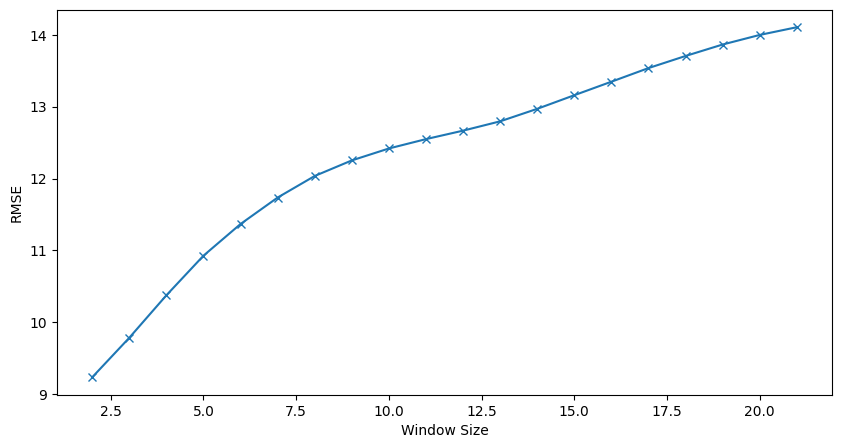

In [35]:
range_size = range(2, 22)
print(len(range_size))
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_ylabel('RMSE')
ax.set_xlabel('Window Size')
ax.plot(range_size, errors_wma, marker='x')

## Exponential Moving Average

In [36]:
def compute_ema(window : int):
    ema = series.ewm(span=window, adjust=False).mean()
    error = sqrt(mean_squared_error(X, ema))
    print(f"Test RMSE: {error:.3f}")
    # plt.figure(figsize=(15,7))
    # plt.plot(X[:500])
    # plt.plot(ema[:500], color='red')
    # plt.show()
    return error, absolute_error_statistics(X, ema)

In [37]:
desc_ema = {}
errors_ema = []
for x in range(2, 22):
    error, stat = compute_ema(x)
    desc_ema[f'Window size {x}'] = stat
    errors_ema.append(error)

Test RMSE: 3.105
Test RMSE: 4.934
Test RMSE: 6.198
Test RMSE: 7.138
Test RMSE: 7.874
Test RMSE: 8.470
Test RMSE: 8.967
Test RMSE: 9.392
Test RMSE: 9.761
Test RMSE: 10.088
Test RMSE: 10.381
Test RMSE: 10.646
Test RMSE: 10.889
Test RMSE: 11.112
Test RMSE: 11.319
Test RMSE: 11.513
Test RMSE: 11.694
Test RMSE: 11.865
Test RMSE: 12.027
Test RMSE: 12.180


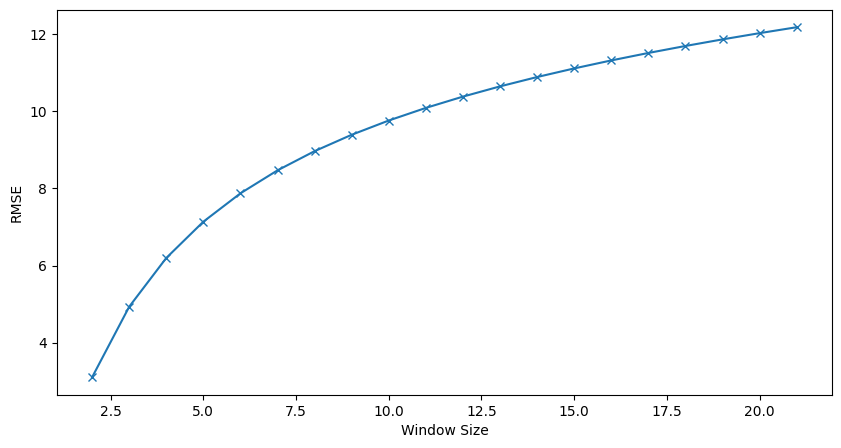

In [38]:
range_size = range(2, 22)
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_ylabel('RMSE')
ax.set_xlabel('Window Size')
ax.plot(range_size, errors_ema, marker='x')

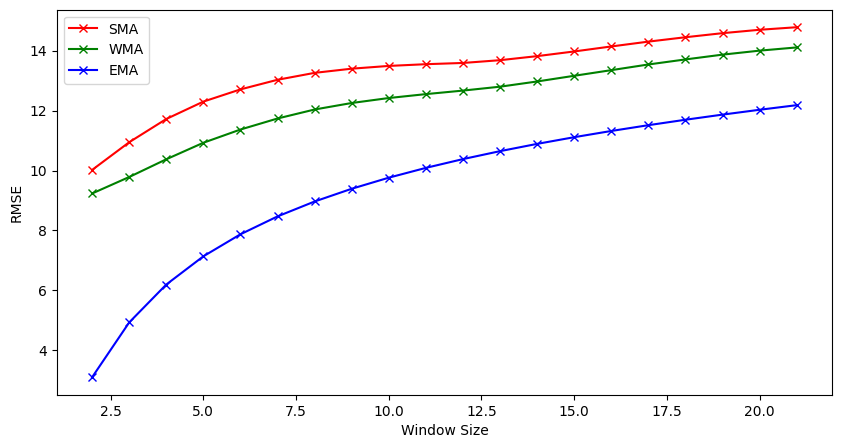

In [40]:
range_size = range(2, 22)
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_ylabel('RMSE')
ax.set_xlabel('Window Size')
ax.plot(range_size, errors, marker='x', color='r', label='SMA')
ax.plot(range_size, errors_wma, marker='x', color='g', label='WMA')
ax.plot(range_size, errors_ema, marker='x', color='b', label='EMA')
plt.legend()
plt.show()

In [70]:
df_sma = pd.DataFrame(desc_sma).describe()
df_wma = pd.DataFrame(desc_wma).describe()
df_ema = pd.DataFrame(desc_ema).describe()
mean_sma = []
mean_wma = []
mean_ema = []

fifty_sma = []
fifty_wma = []
fifty_ema = []

max_sma = []
max_wma = []
max_ema = []

for item in df_sma.axes[1]:
    mean_sma.append(df_sma[item]['mean'])
    mean_wma.append(df_wma[item]['mean'])
    mean_ema.append(df_ema[item]['mean'])

    fifty_sma.append(df_sma[item]['50%'])
    fifty_wma.append(df_wma[item]['50%'])
    fifty_ema.append(df_ema[item]['50%'])

    max_sma.append(df_sma[item]['max'])
    max_wma.append(df_wma[item]['max'])
    max_ema.append(df_ema[item]['max'])


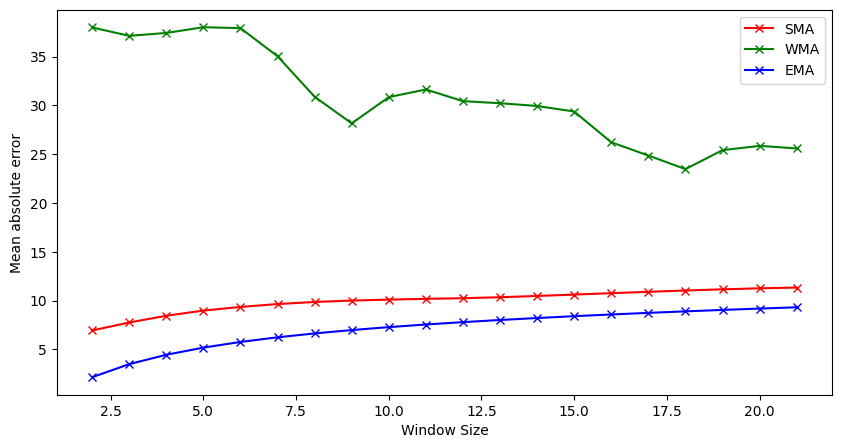

In [71]:
range_size = range(2, 22)
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Window Size')
ax.plot(range_size, mean_sma, marker='x', color='r', label='SMA')
ax.plot(range_size, mean_wma, marker='x', color='g', label='WMA')
ax.plot(range_size, mean_ema, marker='x', color='b', label='EMA')
plt.legend()
plt.show()

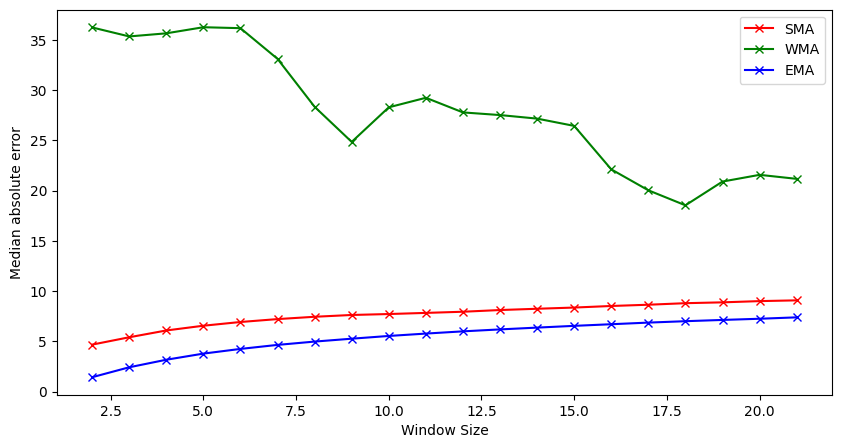

In [75]:
range_size = range(2, 22)
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_ylabel('Median absolute error')
ax.set_xlabel('Window Size')
ax.plot(range_size, fifty_sma, marker='x', color='r', label='SMA')
ax.plot(range_size, fifty_wma, marker='x', color='g', label='WMA')
ax.plot(range_size, fifty_ema, marker='x', color='b', label='EMA')
plt.legend()
plt.show()

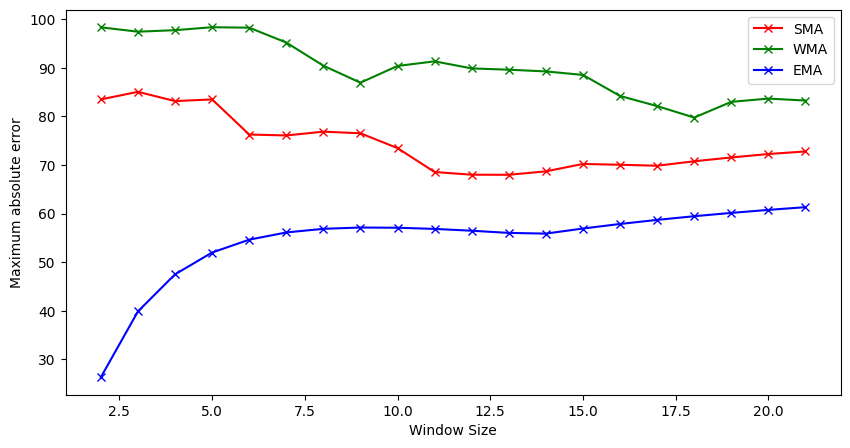

In [76]:
range_size = range(2, 22)
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_ylabel('Maximum absolute error')
ax.set_xlabel('Window Size')
ax.plot(range_size, max_sma, marker='x', color='r', label='SMA')
ax.plot(range_size, max_wma, marker='x', color='g', label='WMA')
ax.plot(range_size, max_ema, marker='x', color='b', label='EMA')
plt.legend()
plt.show()